# Linear quantum photonic circuits as Gaussian kernel samplers

The goal of this notebook is to reproduce the quantum photonic circuit as a Gaussian kernel sampler from [this paper](https://arxiv.org/abs/2107.05224) and analyse its expressive power based on the number of photon used. Then, we will use our trained circuit for a classification task by feeding the approximated similarity matrix to a Support Vector Machine (SVM).

To train our circuit, we will use MerLin which applies the gradient descent algorithm and allows the usage of quantum components mixed with PyTorch structures to build and optimize a hybrid model.

## 0. Imports and prep

In [1]:
import matplotlib.pyplot as plt
import perceval as pcvl
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from tqdm import tqdm
import random

# Import from our custom packages
from merlin import QuantumLayer, OutputMappingStrategy

## 1. Define input data (squared Euclidean distance between x and zero)

In [2]:
# We want x form -pi to pi
x = np.linspace(-np.pi, np.pi, num=int(2 * np.pi / 0.05) + 1)
# We will use x_on_pi for visualization
x_on_pi = x / np.pi
# delta will be the input to our quantum model
delta = (x - 0)**2

def target_function(delta, sigma=1.0):
    return np.exp(-delta/(2*sigma*sigma))

gauss_025 = target_function(delta, sigma=0.25)
gauss_033 = target_function(delta, sigma=0.33)
gauss_050 = target_function(delta, sigma=0.50)
gauss_100 = target_function(delta, sigma=1.00)

Let's visualize our different Gaussians.

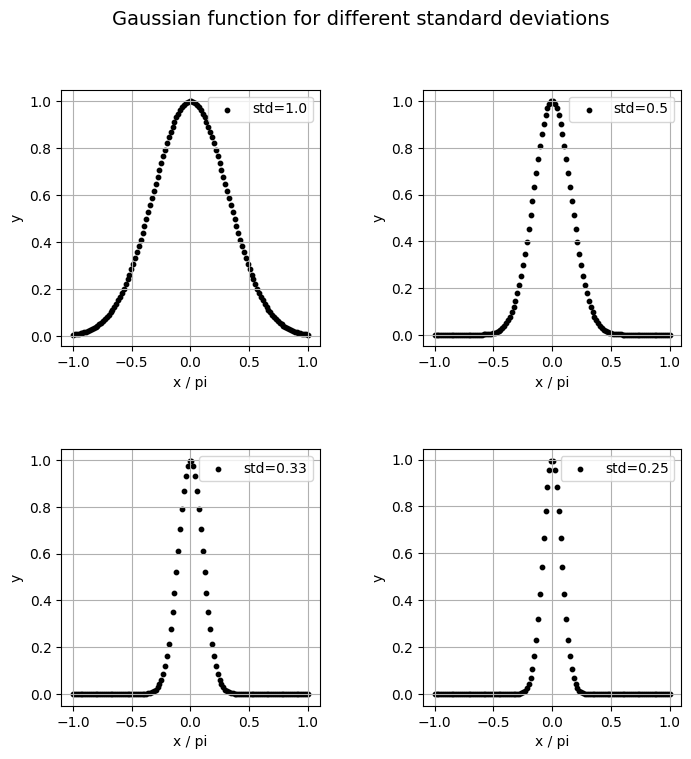

<Figure size 640x480 with 0 Axes>

In [3]:
# Plot using matplotlib
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(hspace=0.4, wspace=0.4)
i = 0
j = 0
ys = [gauss_025, gauss_033, gauss_050, gauss_100]
ys = list(reversed(ys))
sigmas = [0.25, 0.33, 0.50, 1.00]
sigmas = list(reversed(sigmas))

for y, sigma in zip(ys, sigmas):
    axis = axs[i // 2][j % 2]
    axis.scatter(x_on_pi, y, label= f"std={sigma}", s=10, color="k")
    axis.set_xlabel('x / pi')
    axis.set_ylabel('y')
    axis.grid(True)
    axis.legend(loc="upper right")
    i += 1
    j += 1

fig.suptitle("Gaussian function for different standard deviations", fontsize=14)
plt.show()
plt.clf()

Let's also define a class for our hyperparameters since we will need it to test the following functions.

In [4]:
class Hyperparams:
    def __init__(self, num_runs=3, num_epochs=100, batch_size=32, lr=0.02, betas=[0.9, 0.999], weight_decay=0, train_circuit=False, scale_type="learned", circuit="mzi"):
        self.num_runs = num_runs
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.betas = betas
        self.weight_decay = weight_decay
        self.train_circuit = train_circuit
        self.scale_type = scale_type
        self.circuit = circuit

basic_hp = Hyperparams()

## 2. Model definition

First, we have to build the quantum circuit that we will use in the model with the help of Perceval. In the reference paper, the circuit used is a simple Mach-Zehnder interferometer (MZI) which is a popular circuit in QML. However, let's also define a general circuit with more trainable parameters that yields better results in our case.

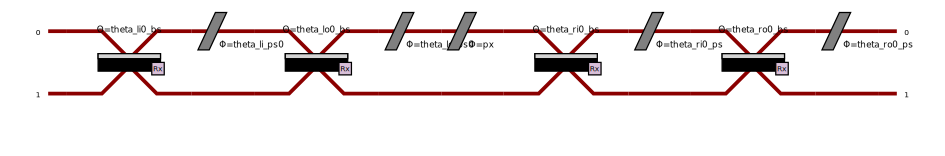

In [5]:
def create_circuit_mzi(args):
    """Create variational quantum classifier with specified number of modes using general meshes"""
    if args.train_circuit:
        wl = pcvl.BS.H(theta=pcvl.P("theta_1"))
    else:
        wl = pcvl.BS.H()

    c_var = pcvl.Circuit(2)
    px = pcvl.P("px")
    c_var.add(0 , pcvl.PS(px))

    if args.train_circuit:
        wr = pcvl.BS.H(theta=pcvl.P("theta_2"))
    else:
        wr = pcvl.BS.H()

    c = pcvl.Circuit(2)
    c.add(0, wl, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, wr, merge=True)

    return c


def create_circuit_general(args):
    """Create variational quantum classifier with specified number of modes using general meshes"""

    wl = pcvl.GenericInterferometer(2,
                                    lambda i: pcvl.BS(pcvl.P(f"theta_li{i}_bs")) // pcvl.PS(pcvl.P(f"theta_li_ps{i}")) // \
                                              pcvl.BS(pcvl.P(f"theta_lo{i}_bs")) // pcvl.PS(pcvl.P(f"theta_lo_ps{i}")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)

    c_var = pcvl.Circuit(2)
    px = pcvl.P("px")
    c_var.add(0 , pcvl.PS(px))

    wr = pcvl.GenericInterferometer(2,
                                    lambda i: pcvl.BS(pcvl.P(f"theta_ri{i}_bs")) // pcvl.PS(pcvl.P(f"theta_ri{i}_ps")) // \
                                              pcvl.BS(pcvl.P(f"theta_ro{i}_bs")) // pcvl.PS(pcvl.P(f"theta_ro{i}_ps")),
                                    shape=pcvl.InterferometerShape.RECTANGLE)

    c = pcvl.Circuit(2)
    c.add(0, wl, merge=True)
    c.add(0, c_var, merge=True)
    c.add(0, wr, merge=True)

    return c

def count_parameters(model):
    """Count trainable parameters in a PyTorch model"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Visualize MZI
"""example_circuit = create_circuit_mzi(basic_hp)
pcvl.pdisplay(example_circuit)"""

# Visualize general circuit
example_circuit = create_circuit_general(basic_hp)
pcvl.pdisplay(example_circuit)

Second, we also need to define a scaling layer that simply multiplies the input by a constant before encoding it in the circuit. That will be the first layer of our model.

In [6]:
class ScaleLayer(nn.Module):
    """
        Multiply the input tensor by a learned or fixed factor.

        Args:
            dim (int): Dimension of the input data to be encoded.
            scale_type (str): Type of scaling method.

        Returns: nn.Module that multiplies the input tensor by a learned or fixed factor.
    """
    def __init__(self, dim, scale_type = "learned"):
        super(ScaleLayer, self).__init__()
        # Create a single learnable parameter (initialized to 0.1 by default)
        if scale_type == "learned":
            self.scale = nn.Parameter(torch.full((dim,), 0.1))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "/pi":
            self.scale = torch.full((dim,), 1 / torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)
        elif scale_type == "0.1":
            self.scale = torch.full((dim,), 0.1)
        elif scale_type == "/2pi":
            self.scale = torch.full((dim,), 1 / (2 * torch.pi))

    def forward(self, x):
        # Element-wise multiplication of each input element by the learned scale
        return x * self.scale

Then, we use MerLin to define the quantum layer that we will use to build our hybrid model. MerLin allows the optimization of the quantum components to run smoothly using the efficient PyTorch framework.

In our specific case, we will determine the input state of the circuit depending on the number of photons.

In [7]:
def create_quantum_layer(num_photons, args):
    """ Create a quantum layer consisting of a VQC for a specific initial state """
    if num_photons % 2 == 0:
        input_state = [num_photons//2, num_photons//2]
    else:
        input_state = [(num_photons//2) + 1, num_photons//2]

    if args.circuit == "general":
        trainable_params = ["theta"]
        circuit = create_circuit_general(args)

    elif args.circuit == "mzi":
        if args.train_circuit:
            trainable_params = ["theta"]
        else:
            trainable_params = []
        circuit = create_circuit_mzi(args)

    else:
        raise NotImplementedError

    scale_layer = ScaleLayer(1, args.scale_type)

    vqc = QuantumLayer(
                input_size=1,
                output_size=1,
                circuit=circuit,
                trainable_parameters=trainable_params,
                input_parameters=["px"],
                input_state= input_state,
                no_bunching=False,
                output_mapping_strategy=OutputMappingStrategy.LINEAR
            )

    model = nn.Sequential(scale_layer, vqc)

    return model


# Let's create some MZI circuits to see their number of parameters and their input state
mzi_2_photons = create_quantum_layer(2, basic_hp)
mzi_4_photons = create_quantum_layer(4, basic_hp)
mzi_6_photons = create_quantum_layer(6, basic_hp)
mzi_8_photons = create_quantum_layer(8, basic_hp)
mzi_10_photons = create_quantum_layer(10, basic_hp)

models = {"MZI 2": mzi_2_photons, "MZI 4": mzi_4_photons, "MZI 6": mzi_6_photons, "MZI 8": mzi_8_photons, "MZI 10": mzi_10_photons}

for name, model in models.items():
    input_state = model[1].input_state
    print(f"{name}: {count_parameters(model)} parameters and input state {input_state}")

MZI 2: 5 parameters and input state [1, 1]
MZI 4: 7 parameters and input state [2, 2]
MZI 6: 9 parameters and input state [3, 3]
MZI 8: 11 parameters and input state [4, 4]
MZI 10: 13 parameters and input state [5, 5]


## 3. Training function

Thanks to MerLin, the optimization of the model has the same programing structure as PyTorch with classical methods.

In [11]:
def train_model(model, X_train, y_train, model_name, args):
    """Train a model and return training metrics"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr, betas=args.betas, weight_decay=0)
    criterion = nn.MSELoss()

    losses = []
    train_mses = []

    model.train()

    pbar = tqdm(range(args.num_epochs), desc=f"Training {model_name}")
    for epoch in pbar:
        permutation = torch.randperm(X_train.size()[0])
        total_loss = 0

        for i in range(0, X_train.size()[0], args.batch_size):
            indices = permutation[i:i + args.batch_size]
            batch_x, batch_y = X_train[indices], y_train[indices]

            outputs = model(batch_x)
            loss = criterion(outputs.squeeze(), batch_y.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / (X_train.size()[0] // args.batch_size)
        losses.append(avg_loss)

        # Evaluation
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train)
            train_mse = mean_squared_error(y_train.numpy(), train_outputs)
            train_mses.append(train_mse)

            pbar.set_description(f"Training {model_name} - Loss: {avg_loss:.4f}, Train MSE: {train_mse:.4f}")

        model.train()

    scaling_factor = model[0].scale
    print(f"After training, scaling factor: {scaling_factor}")
    return {
        'losses': losses,
        'train_mses': train_mses,
    }

In [12]:
def train_models_multiple_runs(num_photons, colors, X_train, ys_info, args):
    """Train all models multiple times and return results"""
    all_results = {}
    ys = ys_info["ys"]
    names = ys_info["names"]

    assert names[0] == "std = 1.00"

    for y, name in zip(ys, names):
        results = {}
        models = []
        for n, color in zip(num_photons, colors):
            print(f"\nTraining MZI with {n} photons ({num_runs} runs) for Gaussian with {name}:")
            pending_models = []
            model_runs = []

            for run in range(args.num_runs):
                # Create a fresh instance of the model for each run
                mzi = create_quantum_layer(n, args)

                print(f"  Run {run+1}/{num_runs}...")
                run_results = train_model(mzi, torch.tensor(X_train, dtype=torch.float).unsqueeze(-1), torch.tensor(y, dtype=torch.float), f"MZI_{n}-run{run+1}", args)
                pending_models.append(mzi)
                model_runs.append(run_results)

            # Find and keep the best model for each number of photons
            index = torch.argmin(torch.tensor([model_run["train_mses"][-1] for model_run in model_runs]))

            models.append(pending_models[index])
            # Store all runs for this model
            results[f"MZI_{n}"] = {
                "runs": model_runs,
                "color": color,
            }
        all_results[f"{name}"] = {
            "results": results,
            "models": models,
        }

    return all_results

In [26]:
# Training set-up
num_photons = [2, 4, 6, 8, 10]
colors = ["blue", "orange", "green", "red", "purple"]
std_names = ["std = 1.00", "std = 0.50", "std = 0.33", "std = 0.25"]
ys_info = {"ys": ys, "names": std_names}

# Hyperparameters
num_runs = 3
num_epochs = 100
batch_size=32
lr=0.02
betas=[0.8, 0.99]
train_circuit = True
scale_type = "learned"  # ["learned", "1", "pi", "2pi", "/pi", "/2pi", "0.1"]
circuit = "general"  # ["mzi", "general"]

args = Hyperparams(num_runs, num_epochs, batch_size, lr, betas, 0, train_circuit, scale_type, circuit)

# Train all models
all_results = train_models_multiple_runs(num_photons, colors, delta, ys_info, args)


Training MZI with 2 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0013, Train MSE: 0.0010: 100%|██████████| 100/100 [00:03<00:00, 27.53it/s]


After training, scaling factor: Parameter containing:
tensor([0.0900], requires_grad=True)
  Run 2/3...


Training MZI_2-run2 - Loss: 0.1055, Train MSE: 0.0763: 100%|██████████| 100/100 [00:03<00:00, 32.03it/s]


After training, scaling factor: Parameter containing:
tensor([0.3477], requires_grad=True)
  Run 3/3...


Training MZI_2-run3 - Loss: 0.0155, Train MSE: 0.0186: 100%|██████████| 100/100 [00:03<00:00, 31.56it/s]


After training, scaling factor: Parameter containing:
tensor([0.0280], requires_grad=True)

Training MZI with 4 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0020, Train MSE: 0.0013: 100%|██████████| 100/100 [00:03<00:00, 30.35it/s]


After training, scaling factor: Parameter containing:
tensor([0.0566], requires_grad=True)
  Run 2/3...


Training MZI_4-run2 - Loss: 0.0010, Train MSE: 0.0007: 100%|██████████| 100/100 [00:03<00:00, 29.89it/s]


After training, scaling factor: Parameter containing:
tensor([0.1047], requires_grad=True)
  Run 3/3...


Training MZI_4-run3 - Loss: 0.0901, Train MSE: 0.0646: 100%|██████████| 100/100 [00:03<00:00, 28.26it/s]


After training, scaling factor: Parameter containing:
tensor([0.3703], requires_grad=True)

Training MZI with 6 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0033, Train MSE: 0.0013: 100%|██████████| 100/100 [00:04<00:00, 23.00it/s]


After training, scaling factor: Parameter containing:
tensor([0.0593], requires_grad=True)
  Run 2/3...


Training MZI_6-run2 - Loss: 0.0019, Train MSE: 0.0014: 100%|██████████| 100/100 [00:04<00:00, 22.61it/s]


After training, scaling factor: Parameter containing:
tensor([0.0797], requires_grad=True)
  Run 3/3...


Training MZI_6-run3 - Loss: 0.0023, Train MSE: 0.0014: 100%|██████████| 100/100 [00:03<00:00, 26.30it/s]


After training, scaling factor: Parameter containing:
tensor([-0.0643], requires_grad=True)

Training MZI with 8 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0002, Train MSE: 0.0001: 100%|██████████| 100/100 [00:03<00:00, 25.84it/s]


After training, scaling factor: Parameter containing:
tensor([0.1066], requires_grad=True)
  Run 2/3...


Training MZI_8-run2 - Loss: 0.0431, Train MSE: 0.0331: 100%|██████████| 100/100 [00:03<00:00, 25.60it/s]


After training, scaling factor: Parameter containing:
tensor([0.0276], requires_grad=True)
  Run 3/3...


Training MZI_8-run3 - Loss: 0.0749, Train MSE: 0.0585: 100%|██████████| 100/100 [00:03<00:00, 25.89it/s]


After training, scaling factor: Parameter containing:
tensor([0.1766], requires_grad=True)

Training MZI with 10 photons (3 runs) for Gaussian with std = 1.00:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0193, Train MSE: 0.0131: 100%|██████████| 100/100 [00:04<00:00, 23.69it/s]


After training, scaling factor: Parameter containing:
tensor([0.0254], requires_grad=True)
  Run 2/3...


Training MZI_10-run2 - Loss: 0.0030, Train MSE: 0.0021: 100%|██████████| 100/100 [00:04<00:00, 24.87it/s]


After training, scaling factor: Parameter containing:
tensor([-0.0585], requires_grad=True)
  Run 3/3...


Training MZI_10-run3 - Loss: 0.0021, Train MSE: 0.0015: 100%|██████████| 100/100 [00:04<00:00, 24.24it/s]


After training, scaling factor: Parameter containing:
tensor([-0.0301], requires_grad=True)

Training MZI with 2 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0166, Train MSE: 0.0122: 100%|██████████| 100/100 [00:03<00:00, 28.13it/s]


After training, scaling factor: Parameter containing:
tensor([-0.1263], requires_grad=True)
  Run 2/3...


Training MZI_2-run2 - Loss: 0.0788, Train MSE: 0.0589: 100%|██████████| 100/100 [00:03<00:00, 28.52it/s]


After training, scaling factor: Parameter containing:
tensor([0.1758], requires_grad=True)
  Run 3/3...


Training MZI_2-run3 - Loss: 0.0155, Train MSE: 0.0104: 100%|██████████| 100/100 [00:03<00:00, 25.32it/s]


After training, scaling factor: Parameter containing:
tensor([0.1162], requires_grad=True)

Training MZI with 4 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0023, Train MSE: 0.0017: 100%|██████████| 100/100 [00:04<00:00, 20.69it/s]


After training, scaling factor: Parameter containing:
tensor([0.1474], requires_grad=True)
  Run 2/3...


Training MZI_4-run2 - Loss: 0.0232, Train MSE: 0.0134: 100%|██████████| 100/100 [00:03<00:00, 26.38it/s]


After training, scaling factor: Parameter containing:
tensor([0.0788], requires_grad=True)
  Run 3/3...


Training MZI_4-run3 - Loss: 0.0142, Train MSE: 0.0099: 100%|██████████| 100/100 [00:03<00:00, 26.04it/s]


After training, scaling factor: Parameter containing:
tensor([0.0894], requires_grad=True)

Training MZI with 6 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0305, Train MSE: 0.0159: 100%|██████████| 100/100 [00:03<00:00, 25.11it/s]


After training, scaling factor: Parameter containing:
tensor([-0.0683], requires_grad=True)
  Run 2/3...


Training MZI_6-run2 - Loss: 0.0172, Train MSE: 0.0107: 100%|██████████| 100/100 [00:04<00:00, 23.86it/s]


After training, scaling factor: Parameter containing:
tensor([0.0781], requires_grad=True)
  Run 3/3...


Training MZI_6-run3 - Loss: 0.0076, Train MSE: 0.0066: 100%|██████████| 100/100 [00:04<00:00, 22.82it/s]


After training, scaling factor: Parameter containing:
tensor([0.0812], requires_grad=True)

Training MZI with 8 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0224, Train MSE: 0.0132: 100%|██████████| 100/100 [00:04<00:00, 23.13it/s]


After training, scaling factor: Parameter containing:
tensor([0.0392], requires_grad=True)
  Run 2/3...


Training MZI_8-run2 - Loss: 0.0177, Train MSE: 0.0127: 100%|██████████| 100/100 [00:04<00:00, 24.39it/s]


After training, scaling factor: Parameter containing:
tensor([0.0745], requires_grad=True)
  Run 3/3...


Training MZI_8-run3 - Loss: 0.0068, Train MSE: 0.0038: 100%|██████████| 100/100 [00:04<00:00, 24.42it/s]


After training, scaling factor: Parameter containing:
tensor([0.0777], requires_grad=True)

Training MZI with 10 photons (3 runs) for Gaussian with std = 0.50:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0164, Train MSE: 0.0150: 100%|██████████| 100/100 [00:05<00:00, 19.96it/s]


After training, scaling factor: Parameter containing:
tensor([0.0644], requires_grad=True)
  Run 2/3...


Training MZI_10-run2 - Loss: 0.0027, Train MSE: 0.0018: 100%|██████████| 100/100 [00:04<00:00, 20.98it/s]


After training, scaling factor: Parameter containing:
tensor([0.0818], requires_grad=True)
  Run 3/3...


Training MZI_10-run3 - Loss: 0.0032, Train MSE: 0.0018: 100%|██████████| 100/100 [00:04<00:00, 21.67it/s]


After training, scaling factor: Parameter containing:
tensor([0.1094], requires_grad=True)

Training MZI with 2 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0319, Train MSE: 0.0242: 100%|██████████| 100/100 [00:03<00:00, 27.01it/s]


After training, scaling factor: Parameter containing:
tensor([0.1078], requires_grad=True)
  Run 2/3...


Training MZI_2-run2 - Loss: 0.0316, Train MSE: 0.0230: 100%|██████████| 100/100 [00:03<00:00, 27.15it/s]


After training, scaling factor: Parameter containing:
tensor([0.1186], requires_grad=True)
  Run 3/3...


Training MZI_2-run3 - Loss: 0.0325, Train MSE: 0.0231: 100%|██████████| 100/100 [00:03<00:00, 25.57it/s]


After training, scaling factor: Parameter containing:
tensor([0.1221], requires_grad=True)

Training MZI with 4 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0617, Train MSE: 0.0456: 100%|██████████| 100/100 [00:04<00:00, 23.83it/s]


After training, scaling factor: Parameter containing:
tensor([0.1848], requires_grad=True)
  Run 2/3...


Training MZI_4-run2 - Loss: 0.0372, Train MSE: 0.0248: 100%|██████████| 100/100 [00:04<00:00, 20.04it/s]


After training, scaling factor: Parameter containing:
tensor([0.0672], requires_grad=True)
  Run 3/3...


Training MZI_4-run3 - Loss: 0.0117, Train MSE: 0.0078: 100%|██████████| 100/100 [00:04<00:00, 23.41it/s]


After training, scaling factor: Parameter containing:
tensor([0.1410], requires_grad=True)

Training MZI with 6 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0448, Train MSE: 0.0355: 100%|██████████| 100/100 [00:04<00:00, 24.00it/s]


After training, scaling factor: Parameter containing:
tensor([0.1407], requires_grad=True)
  Run 2/3...


Training MZI_6-run2 - Loss: 0.0321, Train MSE: 0.0225: 100%|██████████| 100/100 [00:04<00:00, 24.66it/s]


After training, scaling factor: Parameter containing:
tensor([0.0881], requires_grad=True)
  Run 3/3...


Training MZI_6-run3 - Loss: 0.0399, Train MSE: 0.0297: 100%|██████████| 100/100 [00:04<00:00, 22.67it/s]


After training, scaling factor: Parameter containing:
tensor([0.0568], requires_grad=True)

Training MZI with 8 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0235, Train MSE: 0.0169: 100%|██████████| 100/100 [00:04<00:00, 22.81it/s]


After training, scaling factor: Parameter containing:
tensor([0.0641], requires_grad=True)
  Run 2/3...


Training MZI_8-run2 - Loss: 0.0019, Train MSE: 0.0017: 100%|██████████| 100/100 [00:04<00:00, 22.93it/s]


After training, scaling factor: Parameter containing:
tensor([0.1514], requires_grad=True)
  Run 3/3...


Training MZI_8-run3 - Loss: 0.0036, Train MSE: 0.0061: 100%|██████████| 100/100 [00:04<00:00, 22.68it/s]


After training, scaling factor: Parameter containing:
tensor([0.1452], requires_grad=True)

Training MZI with 10 photons (3 runs) for Gaussian with std = 0.33:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0118, Train MSE: 0.0083: 100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


After training, scaling factor: Parameter containing:
tensor([0.1109], requires_grad=True)
  Run 2/3...


Training MZI_10-run2 - Loss: 0.0665, Train MSE: 0.0497: 100%|██████████| 100/100 [00:05<00:00, 18.79it/s]


After training, scaling factor: Parameter containing:
tensor([0.4000], requires_grad=True)
  Run 3/3...


Training MZI_10-run3 - Loss: 0.0043, Train MSE: 0.0032: 100%|██████████| 100/100 [00:05<00:00, 19.93it/s]


After training, scaling factor: Parameter containing:
tensor([0.1324], requires_grad=True)

Training MZI with 2 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_2-run1 - Loss: 0.0635, Train MSE: 0.0465: 100%|██████████| 100/100 [00:07<00:00, 13.54it/s]


After training, scaling factor: Parameter containing:
tensor([0.2758], requires_grad=True)
  Run 2/3...


Training MZI_2-run2 - Loss: 0.0505, Train MSE: 0.0372: 100%|██████████| 100/100 [00:04<00:00, 21.60it/s]


After training, scaling factor: Parameter containing:
tensor([0.3713], requires_grad=True)
  Run 3/3...


Training MZI_2-run3 - Loss: 0.0377, Train MSE: 0.0263: 100%|██████████| 100/100 [00:03<00:00, 26.09it/s]


After training, scaling factor: Parameter containing:
tensor([0.1109], requires_grad=True)

Training MZI with 4 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_4-run1 - Loss: 0.0565, Train MSE: 0.0431: 100%|██████████| 100/100 [00:04<00:00, 24.54it/s]


After training, scaling factor: Parameter containing:
tensor([0.0561], requires_grad=True)
  Run 2/3...


Training MZI_4-run2 - Loss: 0.0567, Train MSE: 0.0417: 100%|██████████| 100/100 [00:03<00:00, 26.79it/s]


After training, scaling factor: Parameter containing:
tensor([0.0214], requires_grad=True)
  Run 3/3...


Training MZI_4-run3 - Loss: 0.0411, Train MSE: 0.0281: 100%|██████████| 100/100 [00:03<00:00, 26.08it/s]


After training, scaling factor: Parameter containing:
tensor([0.0627], requires_grad=True)

Training MZI with 6 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_6-run1 - Loss: 0.0395, Train MSE: 0.0298: 100%|██████████| 100/100 [00:04<00:00, 24.83it/s]


After training, scaling factor: Parameter containing:
tensor([0.0625], requires_grad=True)
  Run 2/3...


Training MZI_6-run2 - Loss: 0.0627, Train MSE: 0.0458: 100%|██████████| 100/100 [00:04<00:00, 24.71it/s]


After training, scaling factor: Parameter containing:
tensor([0.4879], requires_grad=True)
  Run 3/3...


Training MZI_6-run3 - Loss: 0.0455, Train MSE: 0.0311: 100%|██████████| 100/100 [00:04<00:00, 24.52it/s]


After training, scaling factor: Parameter containing:
tensor([0.0537], requires_grad=True)

Training MZI with 8 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_8-run1 - Loss: 0.0221, Train MSE: 0.0160: 100%|██████████| 100/100 [00:04<00:00, 21.87it/s]


After training, scaling factor: Parameter containing:
tensor([0.0780], requires_grad=True)
  Run 2/3...


Training MZI_8-run2 - Loss: 0.0249, Train MSE: 0.0144: 100%|██████████| 100/100 [00:04<00:00, 22.29it/s]


After training, scaling factor: Parameter containing:
tensor([0.1133], requires_grad=True)
  Run 3/3...


Training MZI_8-run3 - Loss: 0.0276, Train MSE: 0.0187: 100%|██████████| 100/100 [00:05<00:00, 19.85it/s]


After training, scaling factor: Parameter containing:
tensor([0.0833], requires_grad=True)

Training MZI with 10 photons (3 runs) for Gaussian with std = 0.25:
  Run 1/3...


Training MZI_10-run1 - Loss: 0.0477, Train MSE: 0.0364: 100%|██████████| 100/100 [00:04<00:00, 20.74it/s]


After training, scaling factor: Parameter containing:
tensor([0.0923], requires_grad=True)
  Run 2/3...


Training MZI_10-run2 - Loss: 0.0302, Train MSE: 0.0173: 100%|██████████| 100/100 [00:04<00:00, 22.59it/s]


After training, scaling factor: Parameter containing:
tensor([0.0871], requires_grad=True)
  Run 3/3...


Training MZI_10-run3 - Loss: 0.0559, Train MSE: 0.0400: 100%|██████████| 100/100 [00:04<00:00, 22.75it/s]

After training, scaling factor: Parameter containing:
tensor([0.3645], requires_grad=True)


## 4. Plot training loss

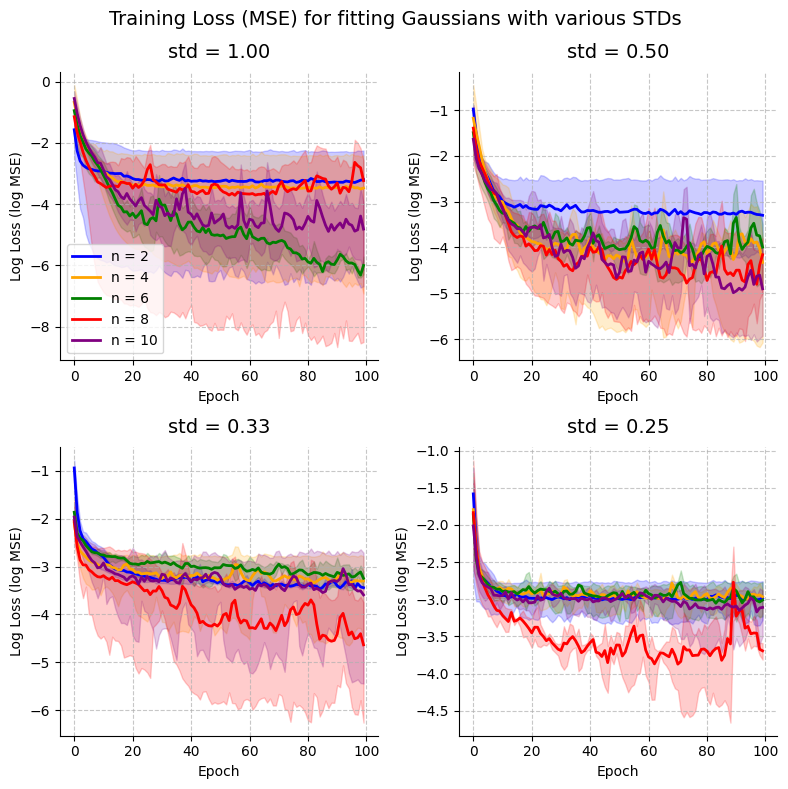

<Figure size 640x480 with 0 Axes>

In [27]:
def plot_training_curves(all_results):
    """Plot training curves for all model variants with average and envelope (only loss shown)"""
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    i = 0
    j = 0

    for y_name, results in all_results.items():
        axis = axs[i // 2, j % 2]
        # Plot each metric
        for model_name, model_data in results["results"].items():
            color = model_data['color']
            linestyle = '-'

            # Get data from all runs
            losses_runs = [run['losses'] for run in model_data['runs']]

            # Calculate mean values across all runs
            epochs = len(losses_runs[0])
            mean_losses = np.log([sum(run[i] for run in losses_runs) / len(losses_runs) for i in range(epochs)])

            # Calculate min and max values for the envelope
            min_losses = np.log([min(run[i] for run in losses_runs) for i in range(epochs)])
            max_losses = np.log([max(run[i] for run in losses_runs) for i in range(epochs)])

            # Plot mean line
            axis.plot(mean_losses, label=f"n = {model_name[4:]}", color=color, linestyle=linestyle, linewidth=2)

            # Plot envelope
            axis.fill_between(range(epochs), min_losses, max_losses, color=color, alpha=0.2)

        # Customize plot
        axis.set_title(f'{y_name}', fontsize=14, pad=10)
        axis.set_xlabel('Epoch')
        axis.set_ylabel('Log Loss (log MSE)')
        if i == 0 and j == 0:
            axis.legend()
        axis.grid(True, linestyle='--', alpha=0.7)
        axis.spines['top'].set_visible(False)
        axis.spines['right'].set_visible(False)
        i += 1
        j += 1

    fig.suptitle('Training Loss (MSE) for fitting Gaussians with various STDs', fontsize=14)
    plt.tight_layout()
    # plt.savefig("./results/training_curves_gaussian_kernels.png")  # To save locally
    plt.show()
    plt.clf()


# Plot training curves
plot_training_curves(all_results)

## 5. Visualize learned functions

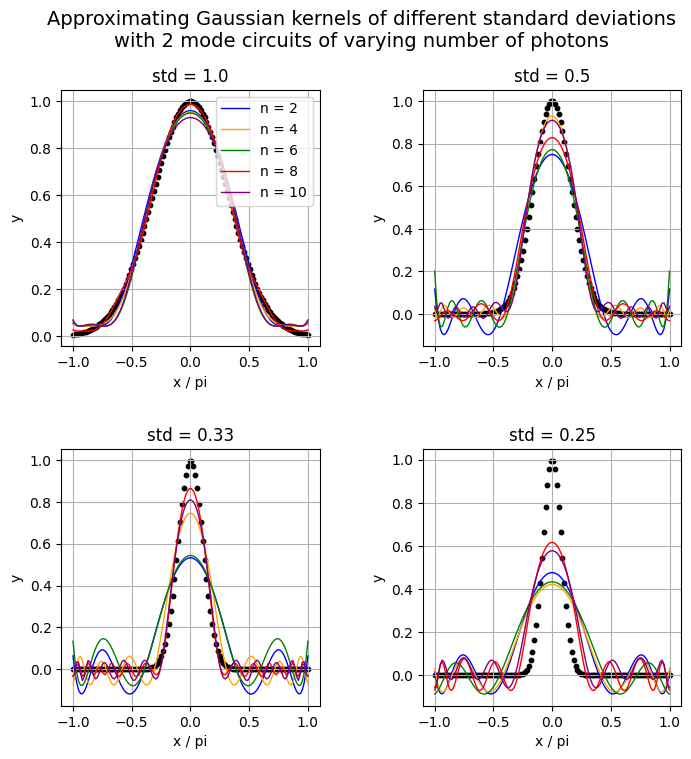

<Figure size 640x480 with 0 Axes>

In [28]:
def visualize_learned_function(results, num_photons, x_on_pi, delta, ys_info):
    """Visualize learned function of different models to compare them with the target function, a Gaussian"""
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    i = 0
    j = 0
    ys = ys_info["ys"]
    y_names = ys_info["names"]
    sigmas = [1.00, 0.50, 0.33, 0.25]
    circuit_names = [f"MZI_{n}" for n in num_photons]

    for y, y_name, sigma in zip(ys, y_names, sigmas):
        axis = axs[i // 2][j % 2]
        y_results = results[f"{y_name}"]["results"]
        y_models = results[f"{y_name}"]["models"]
        for circuit_name, model in zip(circuit_names, y_models):
            model_results = y_results[circuit_name]
            color = model_results["color"]
            model.eval()
            with torch.no_grad():
                output = model(torch.tensor(delta, dtype=torch.float).unsqueeze(-1))
            axis.plot(x_on_pi, output.detach().numpy(), label=f"n = {circuit_name[4:]}", color=color, linewidth=1)

        axis.scatter(x_on_pi, y, s=10, color="k")

        axis.set_xlabel('x / pi')
        axis.set_ylabel('y')
        axis.grid(True)
        if i == 0 and j == 0:
            axis.legend(loc="upper right")
        axis.title.set_text(f"std = {sigma}")
        i += 1
        j += 1
    fig.suptitle("Approximating Gaussian kernels of different standard deviations\nwith 2 mode circuits of varying number of photons", fontsize=14)
    # plt.savefig("./results/gaussian_kernel_quantum.png")  # To save the figure locally
    plt.show()
    plt.clf()
    return


visualize_learned_function(all_results, num_photons, x_on_pi, delta, ys_info)

This is not as accurate as we would have wanted but we can work with it. For a standard deviation of 1, our models achieve good results but as we decrease its value, the models achieved worse results, especially the ones with fewer photons. Ideally, this is supposed to show that increasing the number of photons also increases the expressivity of the quantum model.

## 6. Application: Using our trained kernel estimators for binary classification

### 6.1 Generate data

Let's generate some 2D datasets for which our trained Gaussian kernel estimator will be useful. Namely, we will work the circle, moon and blob datasets from sklearn.

In [30]:
def get_circle(num_samples, noise=0.1):
    X, y = make_circles(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42
    )
    return X, y


def get_moon(num_samples, noise=0.2):
    X, y = make_moons(
        n_samples=num_samples,  # number of data points
        noise=noise,
        random_state=42
    )
    return X, y


def get_blobs(num_samples, centers=2):
    X, y = make_blobs(
        n_samples=num_samples,
        centers=centers,
        cluster_std=4.0,
        random_state=42
    )
    return X, y


def get_visual_sample(x, y, title):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    axs[0].scatter(x[0][:, 0], x[0][:, 1], c=y[0], cmap='bwr', edgecolor='k')
    axs[0].set_xlabel("x1")
    axs[0].set_ylabel("x2")
    axs[1].scatter(x[1][:, 0], x[1][:, 1], c=y[1], cmap='bwr', edgecolor='k')
    axs[1].set_xlabel("x1")
    axs[1].set_ylabel("x2")
    axs[2].scatter(x[2][:, 0], x[2][:, 1], c=y[2], cmap='bwr', edgecolor='k')
    axs[2].set_xlabel("x1")
    axs[2].set_ylabel("x2")
    axs[0].title.set_text(title[0])
    axs[1].title.set_text(title[1])
    axs[2].title.set_text(title[2])

    # plt.savefig("./results/data_visualization.png")  # To save figure locally
    plt.show()
    plt.clf()
    return

The next step is scaling the data and separating it to train and test sets.

One thing to keep in mind during scaling of the data is that the range of squared distances between points on which we have trained our gaussian kernel model is \[0, pi**2] since our initial x is defined on \[0, pi] and the distance is computed between x and zero. So it would be ideal if the scaling of our data takes that into account so our model only receives values within its training domain. To do so, we define a scaling factor adjusted to our situation.

Circular training set: 120 samples, 2 features
Circular test set: 80 samples, 2 features
Moon training set: 120 samples, 2 features
Moon test set: 80 samples, 2 features
Blob training set: 120 samples, 2 features
Blob test set: 80 samples, 2 features


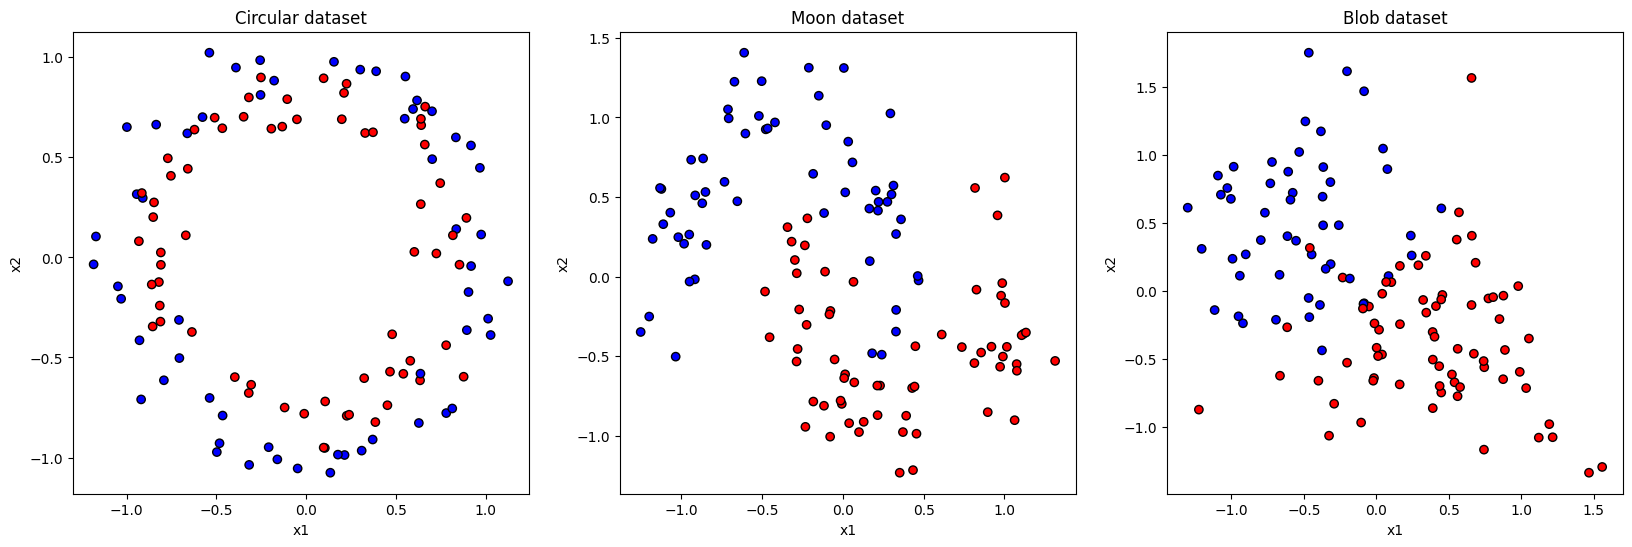

<Figure size 640x480 with 0 Axes>

In [31]:
def prepare_data(scaling_factor=0.65):
    """Standardization, type changing and splitting of the data for preparation"""
    x_circ, y_circ = get_circle(200)
    x_moon, y_moon = get_moon(200)
    x_blob, y_blob = get_blobs(200)

    x_circ_train, x_circ_test, y_circ_train, y_circ_test = train_test_split(x_circ, y_circ, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_circ_train = torch.FloatTensor(x_circ_train)
    y_circ_train = torch.FloatTensor(y_circ_train)
    x_circ_test = torch.FloatTensor(x_circ_test)
    y_circ_test = torch.FloatTensor(y_circ_test)

    scaler = StandardScaler()
    x_circ_train = torch.FloatTensor(scaler.fit_transform(x_circ_train)) * scaling_factor
    x_circ_test = torch.FloatTensor(scaler.transform(x_circ_test)) * scaling_factor

    print(f"Circular training set: {x_circ_train.shape[0]} samples, {x_circ_train.shape[1]} features")
    print(f"Circular test set: {x_circ_test.shape[0]} samples, {x_circ_test.shape[1]} features")

    x_moon_train, x_moon_test, y_moon_train, y_moon_test = train_test_split(x_moon, y_moon, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_moon_train = torch.FloatTensor(x_moon_train)
    y_moon_train = torch.FloatTensor(y_moon_train)
    x_moon_test = torch.FloatTensor(x_moon_test)
    y_moon_test = torch.FloatTensor(y_moon_test)

    scaler = StandardScaler()
    x_moon_train = torch.FloatTensor(scaler.fit_transform(x_moon_train)) * scaling_factor
    x_moon_test = torch.FloatTensor(scaler.transform(x_moon_test)) * scaling_factor

    print(f"Moon training set: {x_moon_train.shape[0]} samples, {x_moon_train.shape[1]} features")
    print(f"Moon test set: {x_moon_test.shape[0]} samples, {x_moon_test.shape[1]} features")

    x_blob_train, x_blob_test, y_blob_train, y_blob_test = train_test_split(x_blob, y_blob, test_size=0.4, random_state=42)

    # Convert data to PyTorch tensors
    x_blob_train = torch.FloatTensor(x_blob_train)
    y_blob_train = torch.FloatTensor(y_blob_train)
    x_blob_test = torch.FloatTensor(x_blob_test)
    y_blob_test = torch.FloatTensor(y_blob_test)

    scaler = StandardScaler()
    x_blob_train = torch.FloatTensor(scaler.fit_transform(x_blob_train)) * scaling_factor
    x_blob_test = torch.FloatTensor(scaler.transform(x_blob_test)) * scaling_factor

    print(f"Blob training set: {x_blob_train.shape[0]} samples, {x_blob_train.shape[1]} features")
    print(f"Blob test set: {x_blob_test.shape[0]} samples, {x_blob_test.shape[1]} features")

    x_train = [x_circ_train, x_moon_train, x_blob_train]
    x_test = [x_circ_test, x_moon_test, x_blob_test]
    y_train = [y_circ_train, y_moon_train, y_blob_train]
    y_test = [y_circ_test, y_moon_test, y_blob_test]

    return x_train, x_test, y_train, y_test


x_train, x_test, y_train, y_test = prepare_data()
# Visualize training data
get_visual_sample(x_train, y_train, title=["Circular dataset", "Moon dataset", "Blob dataset"])

### 6.2 Compute kernel value for every pair of data points using our quantum model

To do so, we first need the delta (squared Euclidean distance) between each pair of points.

In [32]:
def calculate_delta(x1, x2):
    """
    Computes squared Euclidean distances between each pair of vectors in x1 and x2.
    x1: Tensor of shape (n1, d)
    x2: Tensor of shape (n2, d)
    Returns: Tensor of shape (n1, n2) with delta[i, j] = ||x1[i] - x2[j]||^2
    """
    # Ensure 2D input
    assert x1.ndim == 2 and x2.ndim == 2, "Inputs must be 2D tensors"

    # Use broadcasting to compute pairwise squared Euclidean distances
    diff = x1[:, None, :] - x2[None, :, :]     # shape (n1, n2, d)
    delta = torch.sum(diff ** 2, dim=2)        # shape (n1, n2)

    # Optional sanity checks
    assert delta.shape[0] == x1.size(0), "First dimension of delta is off"
    assert delta.shape[1] == x2.size(0), "Second dimension of delta is off"

    return delta

Calculate the kernel value with our previously defined quantum model.

In [33]:
def get_kernel(model, delta):
    """
    Efficiently apply `model` to each element in the `delta` matrix.
    Assumes model maps a scalar input to a scalar output.
    """
    model.eval()
    with torch.no_grad():
        flat_input = delta.view(-1, 1)  # shape (n1 * n2, 1)
        output = model(flat_input)     # shape (n1 * n2, 1) or (n1 * n2,)
        kernel_matrix = output.view(delta.shape)
    return kernel_matrix

### 6.3 Use a linear SVM for classification

In [34]:
def train_svm(k_train, k_test, y_train, y_test):
    clf = SVC(kernel='precomputed')
    clf.fit(k_train.numpy(), y_train.numpy())

    y_pred = clf.predict(k_test.numpy())
    accuracy = accuracy_score(y_test.numpy(), y_pred)
    return accuracy

### 6.4 Run the training and collect the test accuracies

In [35]:
accs = {"circular_acc": [], "moon_acc": [], "blob_acc": [], "std_name": [], "n_photons": []}

std_names = ys_info["names"]
for std_name in std_names:
    for i in range(5):
        n_photons = (i+1) * 2
        model = all_results[std_name]["models"][i]

        # Calculate delta
        delta_train_circ = calculate_delta(x_train[0], x_train[0])
        delta_test_circ = calculate_delta(x_test[0], x_train[0])
        delta_train_moon = calculate_delta(x_train[1], x_train[1])
        delta_test_moon = calculate_delta(x_test[1], x_train[1])
        delta_train_blob = calculate_delta(x_train[2], x_train[2])
        delta_test_blob = calculate_delta(x_test[2], x_train[2])

        # Calculate kernel
        kernel_train_circ = get_kernel(model, delta_train_circ)
        kernel_test_circ = get_kernel(model, delta_test_circ)
        kernel_train_moon = get_kernel(model, delta_train_moon)
        kernel_test_moon = get_kernel(model, delta_test_moon)
        kernel_train_blob = get_kernel(model, delta_train_blob)
        kernel_test_blob = get_kernel(model, delta_test_blob)

        # Train SVM
        circular_acc = train_svm(kernel_train_circ, kernel_test_circ, y_train[0], y_test[0])
        moon_acc = train_svm(kernel_train_moon, kernel_test_moon, y_train[1], y_test[1])
        blob_acc = train_svm(kernel_train_blob, kernel_test_blob, y_train[2], y_test[2])

        accs["circular_acc"].append(circular_acc)
        accs["moon_acc"].append(moon_acc)
        accs["blob_acc"].append(blob_acc)
        accs["std_name"].append(std_name)
        accs["n_photons"].append(n_photons)

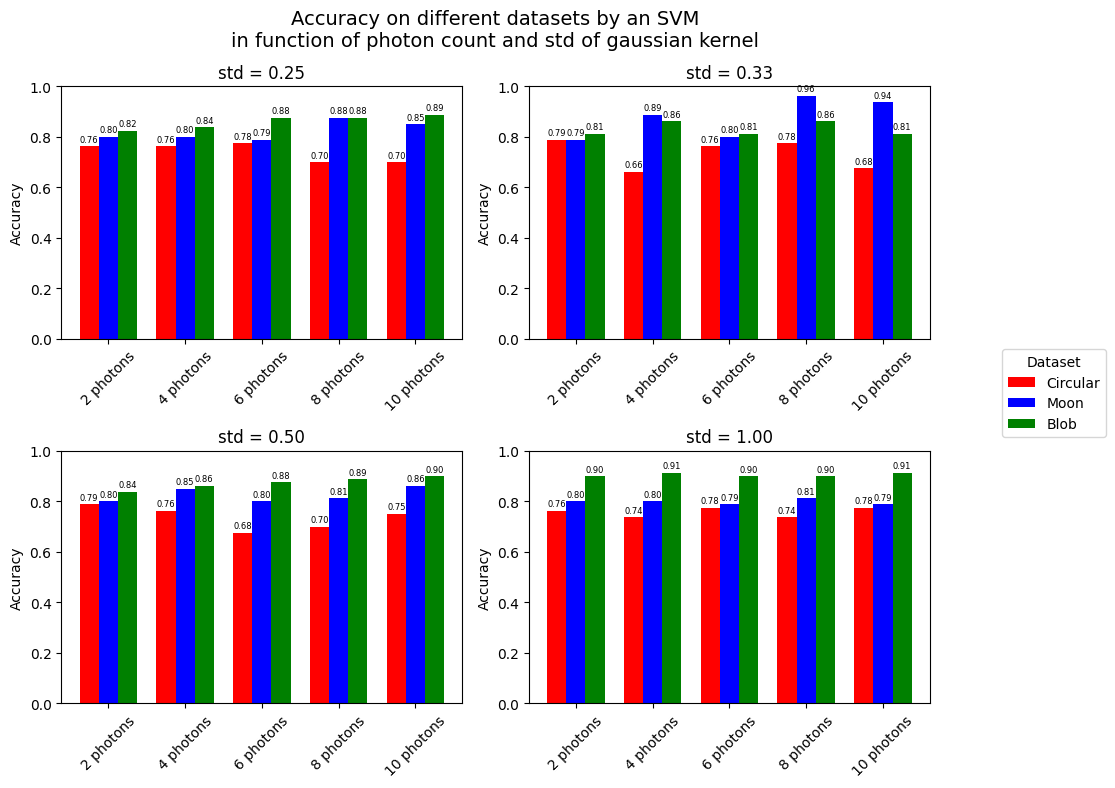

<Figure size 640x480 with 0 Axes>

In [37]:
def visualize_accuracies(results):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    stds = sorted(set(accs["std_name"]))
    datasets = ["circular", "moon", "blob"]
    colors = ["red", "blue", "green"]
    bar_width = 0.25

    for i, std in enumerate(stds):
        axis = axs[i // 2, i % 2]

        # Get data for this std
        std_indices = [j for j, s in enumerate(accs["std_name"]) if s == std]
        n_photon_vals = sorted(set([accs["n_photons"][j] for j in std_indices]))

        # Collect bars for each dataset
        positions = np.arange(len(n_photon_vals))
        for k, dataset in enumerate(datasets):
            y_vals = []
            for n in n_photon_vals:
                idx = next(j for j in std_indices if accs["n_photons"][j] == n)
                y = accs[f"{dataset}_acc"][idx]
                y_vals.append(y)

            x_pos = positions + k * bar_width
            bars = axis.bar(x_pos, y_vals, width=bar_width, label=dataset.capitalize(), color=colors[k])

            for bar in bars:
                height = bar.get_height()
                axis.text(
                    bar.get_x() + bar.get_width() / 2,  # x position: center of the bar
                    height + 0.01,                      # y position: slightly above the bar
                    f"{height:.2f}",                    # format to 2 decimal places
                    ha='center', va='bottom', fontsize=6  # alignment and font size
                )

        # Axis formatting
        axis.set_title(f"{std}")
        axis.set_xticks(positions + bar_width)
        axis.set_xticklabels([str(n) + " photons" for n in n_photon_vals], rotation=45)
        axis.set_ylabel("Accuracy")
        axis.set_ylim(0, 1)

    plt.suptitle("Accuracy on different datasets by an SVM\nin function of photon count and std of gaussian kernel", fontsize=14)
    # Add a global legend on the right
    handles, labels = axs[0, 0].get_legend_handles_labels()  # or any axis with plotted bars
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), title="Dataset")

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space on the right for the legend
    # plt.savefig("./results/svm_accuracies_quantum_kernel.png", bbox_inches='tight')  # To save locally
    plt.show()
    plt.clf()
    return

visualize_accuracies(accs)

Thus, we see that the approximated Gaussian kernels are useful for classification since none of these datasets would have allowed a linear SVM to reach accuracies of this height. There is not clear tendency within these results. However, one could say that models with 8 or 10 photons yield better results. Also, the results on the blob dataset seem to be better with kernels of bigger std. Finally, we can observe that the best results are reached by approximating a Gaussian of std = 0.33 with 8 photons.

Further analysis would be required to discover the advantages of using a quantum layer instead of calculating the Gaussian kernel directly.